## Libraries

In [2]:
import re
import unidecode
import math
import spacy
import pandas as pd

from random import shuffle
from random import choice

from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from millenlp.preprocessing import PreProc
from millenlp.embeddings import FastTextVec
from millenlp.state_models.shallow_model import ShallowModel

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.fasttext import FastText, FastTextTrainables 
from gensim.models.word2vec import Word2Vec

import queue
from threading import Thread

from graphviz import Digraph

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.palettes import Blues9,Spectral11,Category10,Set1,Set2,Category20
from bokeh.io import reset_output
from bokeh.models import BoxSelectTool,CustomJS, ColumnDataSource,Legend

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import plotly
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='dannyehb92', api_key='bGLweiL9ZJD4pkLmavvs')

In [3]:
# Setting option to display all information in pandas columns
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 2000)
# pd.expand_repr = True
# pd.notebook_repr_html = True
# output_notebook()

## Important Functions

In [3]:
def preping_bokeh_clustering(original_data,features,column,cluster):
    
    color_dic = {}
    L = cluster['ClusterNumber'].unique().shape[0]
    nums = [x for x in range(L)]
    shuffle(nums)
    if L <= 20:
        for k,value in enumerate(cluster['ClusterNumber'].unique()):
            if L >10:
                color_dic[value] = Category20[20][nums[k]]
            else:
                color_dic[value] = Category10[10][nums[k]]
    else:
            
        hexa = ['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f']
        color_dic = {}
        for k,value in enumerate(cluster['ClusterNumber'].unique()):
            color_dic[value] = ''.join([choice(hexa) if i != 0 else '#' for i in range(7)])

    df_bokeh = pd.DataFrame(np.concatenate((features,
                                            original_data[column].values.reshape(-1,1),
                                            original_data['lemma'].values.reshape(-1,1),
                                            cluster['ClusterNumber'].values.reshape(-1,1)),axis=1),

                            columns=['x','y','Message','lemma','Label'])
    
    df_bokeh['color'] = cluster.ClusterNumber.apply(lambda x: color_dic[x])
    
    TOOLTIPS = [("Index", "$index"),
            ("(x,y)", "(@x, @y)"),
            ("Message", "@{Message}"),
            ("Lemmas", "@{lemma}"),
            ("Label", "@{Label}")]

    return df_bokeh, TOOLTIPS

def scatter(source,TOOLTIPS,classes):
    p = figure(title="Fasttext and TSNE", 
           x_axis_label='x', y_axis_label='y',
           plot_width=950, plot_height=500, 
           tools = 'lasso_select,box_zoom,pan,poly_select,tap,wheel_zoom,save,zoom_out,crosshair,hover,reset,help',
           tooltips=TOOLTIPS)
    
    legend_it = []
    cluster_size = []
    for label in range(0,classes):
        cluster_size.append((label,source[source['Label']==label].shape[0]))
    cluster_size = sorted(cluster_size, key = lambda x: x[1], reverse=True)
    
    for label in list(np.array(cluster_size)[:,0]):
        c = p.scatter(x = "x",y = "y",size=5,
                      line_color="black", color="color", 
                      alpha=0.7, source=ColumnDataSource(source[source['Label']==label]))
        legend_it.append((str(label), [c]))
    
    legend = Legend(items=legend_it, location=(0, -30))
    legend.click_policy="hide"
    p.add_layout(legend, 'right')
    
    show(p)

def ranking_by_label_prediction(data_set,model,label):
    data_set['Prediction'] = data_set['iteration'].apply(lambda x : model._classifier.predict(model._vectorizer.transform([model.preprocessing(x)]))[0])
    data_set[model._classifier.classes_] = pd.DataFrame(data_set['iteration'].apply(lambda x : model._classifier.predict_proba(model._vectorizer.transform([model.preprocessing(x)]))[0]).values.tolist(), 
                                                                                index= data_set.index)
    return data_set.sort_values([label], ascending = [0])

def vocabulary(model, label_to_sort):
    
    if 'FastText' is model._vectorizer._embedding.__class__.__name__:
        classes = model._classifier.classes_
        word_dict = list(model._vectorizer._embedding.wv.vocab.keys())

        features_words = pd.DataFrame(model._vectorizer.transform(word_dict), 
                                      columns = list(range(model._vectorizer._num_features)))
        features_words = features_words.astype(float)

        features_ranked = pd.DataFrame(word_dict, columns = ['feature'])
        for i, label in enumerate(classes):
            topics = [label_to_sort] if len(model._classifier.classes_) < 3 else model._classifier.classes_.tolist()
            ranking_dim = pd.DataFrame(np.transpose(model._classifier.coef_), columns=topics)
            ranking_dim['feature'] = list(range(model._vectorizer._num_features))
            ranking_dim = ranking_dim.round(2).sort_values(label_to_sort, ascending=False).reset_index(drop=True)
            ranking_dim = ranking_dim[ranking_dim[model._classifier.classes_].idxmax(axis=1)==label]

            feature_weight = pd.DataFrame()
            features_words_filtered = features_words[ranking_dim.feature.tolist()]
            feature_weight[label] = np.dot(features_words_filtered.values,
                                           ranking_dim[label_to_sort].values) / features_words_filtered.shape[1]
            features_ranked = pd.concat([features_ranked,feature_weight], axis = 1)

        features_ranked = features_ranked.sort_values(by=[label_to_sort], ascending = False)
        
    elif 'TfidfVectorizer' is model._vectorizer._embedding.__class__.__name__:
        
        topics = [label_to_sort] if len(model._classifier.classes_) < 3 else model._classifier.classes_.tolist()
#         topics = model._classifier.classes_.tolist()
        features_ranked = pd.DataFrame(np.transpose(model._classifier.coef_), columns=topics)
        features_ranked['feature'] = model._vectorizer._embedding.get_feature_names()
        features_ranked = features_ranked.round(2).sort_values(label_to_sort, ascending=False).reset_index(drop=True)
        
    return features_ranked

def node_coef(data_set,coef_features,msg_col,label_col,feature,per_class):
    if per_class:
        data_set = data_set[data_set.label == label_col]
    count_feature = data_set[data_set[msg_col].str.contains(feature)].shape[0]
    if feature in coef_features.feature.values:
        coef = coef_features[coef_features.feature.isin([feature])][label_col].values[0]
    else:
        coef = 'Not in Dict'
    feature_info = pd.DataFrame(np.array([[feature,count_feature,round(coef,2)]]),
                                      columns = ['feature','counts','coef'])
    return feature_info 

def prob_around_word(data_set,coef_features,regex,msg_col,label_col, feature, per_class):
    
    if per_class:
        data_set = data_set[data_set.label == label_col]
        
    regex = regex.replace('{}',feature)
    look_around = data_set[msg_col].str.extract(regex, expand=False)
    count_feature = data_set[data_set[msg_col].str.contains(feature)].shape[0]
    
    if isinstance(look_around, pd.DataFrame):
        look_around = look_around.iloc[:,-1]
        
    look_around = look_around.dropna().value_counts().to_frame().reset_index()  
    look_around.columns = ['feature','counts']
    look_around['probability'] = np.divide(look_around.counts.values,np.sum(look_around.counts.values))*100
    look_around['coef'] = [round(coef_features[coef_features.feature.isin([word])][label_col].values[0],2)
                           if word in coef_features.feature.values else 'Not in Dict' 
                           for word in look_around.feature.values]
    return look_around

def left_parents(data_set, child, graph, dot):
    for parent in data_set.feature.values:
        data = data_set[data_set.feature==parent]
        if parent in list(graph.keys()):
            graph[parent][child] = (data.probability.values[0],
                                    data.counts.values[0],
                                    data.coef.values[0])
            dot = set_graph_atr(dot, data.coef.values[0])
            dot.node(parent,'{} \n Count = {} \n Coef = {}'.format(parent,
                                                                   data.counts.values[0],
                                                                   data.coef.values[0]),
                    shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(data.probability.values[0],2)))),weight='1.2')
        else:
            graph[parent] = {child: (data.probability.values[0],
                                     data.counts.values[0],
                                     data.coef.values[0])}
            dot = set_graph_atr(dot, data.coef.values[0])
            dot.node(parent,'{} \n Count = {} \n Coef = {}'.format(parent,
                                                                   data.counts.values[0],
                                                                   data.coef.values[0]),
                    shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(data.probability.values[0],2)))),weight='1.2')
    return graph, dot

def right_child(data_set, parent, graph,dot):
    if parent in list(graph.keys()):
        graph[parent] = {**graph[parent],**dict(zip(data_set.feature.values,
                                                   zip(data_set.probability.values,
                                                       data_set.counts.values,
                                                      data_set.coef.values)))}
        for child, counts, prob, coef in data_set.values:
            dot = set_graph_atr(dot, coef)
            dot.node(child,'{} \n Count = {} \n Coef = {}'.format(child,
                                                                  counts,
                                                                  coef),shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(prob,2)))),weight='1.2')
        
    else:
        graph[parent] = dict(zip(data_set.feature.values,
                               zip(data_set.probability.values,
                                   data_set.counts.values,
                                   data_set.coef.values)))
        for child, counts, prob, coef in data_set.values:
            dot = set_graph_atr(dot, coef)
            dot.node(child,'{} \n Count = {} \n Coef = {}'.format(child,
                                                                  counts,
                                                                  coef),shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(prob,2)))),weight='1.2')
    return graph, dot

def set_graph_atr(dot, coef):
    if isinstance(coef,str):
        dot.attr('node',style='filled', color='lightgrey')
    else:
        if coef > 0:
            dot.attr('node',style='filled', color='green')
        elif coef <= 0:
            dot.attr('node', style='filled', color='red')
    return dot

def create_adjacency_graph(data_set,model,label,num_features,per_class,levels):

    coef_vocab = vocabulary(model,label)
    features = coef_vocab.feature.iloc[:num_features+1].values.tolist()
    feature = features[num_features]
    
    check_around = ['(\w+(?=(?:\s(?:\w+\s){level}){}))',
                    '(({}\s)(\s*(\w+)){0,level})']
    
    graph = {}
    dot = Digraph(comment='Data Feature Probability Relationship')
    feature_data = node_coef(data_set,coef_vocab,'iteration',label,feature,per_class)
    dot.attr('node',style='filled', color='blue')
    dot.node(feature_data.feature.values[0],'{} \n Count = {} \n Coef = {}'.format(feature_data.feature.values[0],
                                                                                   feature_data.counts.values[0],
                                                                                   feature_data.coef.values[0]))
    for side in range(levels):
        where_to_check = check_around[side].replace('level',str(side))
        for level in range(levels):
            words_lvl1 = prob_around_word(data_set,
                                          coef_vocab,
                                          where_to_check,
                                          'iteration',
                                          label,
                                          feature,
                                          per_class).query('probability>5')
            if not side and level == 0:
                graph, dot = left_parents(words_lvl1, feature, graph, dot)
            elif not side and level == 1:
                for word in words_lvl1.feature.values:
                    
                    words_lvl2 = prob_around_word(data_set,
                                                  coef_vocab,
                                                  where_to_check,
                                                  'iteration',
                                                  label,
                                                  word,
                                                  per_class).query('probability>5')
                    graph, dot = left_parents(words_lvl2, word, graph, dot)
            elif side and level == 0:   
                graph, dot = right_child(words_lvl1, feature, graph, dot)
            elif side and level == 1:
                for word in words_lvl1.feature.values:
                    words_lvl2 = prob_around_word(data_set,
                                                  coef_vocab,
                                                  where_to_check,
                                                  'iteration',
                                                  label,
                                                  word,
                                                  per_class).query('probability>5')
                    graph, dot = right_child(words_lvl2, word, graph, dot)
    return dot

def word_freq(DataFrame,Class,label,text):
    
    stopwords_spanish = stopwords.words('spanish')
    vectorizer_perclass = vec = CountVectorizer(strip_accents='ascii',ngram_range=(1,2),stop_words=stopwords_spanish,max_df=1.0,min_df=1)
    bag_of_words = vectorizer_perclass.fit_transform(DataFrame[DataFrame[label]== Class][text].values).toarray()
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return pd.DataFrame(words_freq, columns = ['Words','Count'])

def centroid_texts(cluter_model,features, data, cluster_num, closest_text_num) :
    cos_sim = cosine_similarity(features,cluter_model.means_)
    euc_dist = euclidean_distances(features,cluter_model.means_)

    idx = []
    cluster = cluster_num
    for value in np.array(sorted(cos_sim[:,cluster], reverse = True)[:closest_text_num]):
        idx.append(np.where(cos_sim[:,cluster] == value)[0].tolist()[0])
    closest_to_centroid = data[data.index.isin(data.index[idx].tolist())]
    try:
        closest_to_centroid.assign(Similarity = np.array(sorted(cos_sim[:,cluster], reverse = True)[:closest_text_num]))
    except:
        pass
    return closest_to_centroid

In [4]:
def markov_matrix(data, label_col, user_col):
    
    tipificaciones = data[label_col].unique()
    num_tipi = tipificaciones.shape[0]
    matrix = np.zeros((num_tipi,num_tipi))

    for user in data[user_col].unique():

        per_user = data[data[user_col] == user]
        num_calls = per_user[label_col].values.shape[0]
        calls = per_user[label_col].values

        for idx in range(num_calls):

            if not idx == num_calls-1:

                try:
                    init = np.where(tipificaciones == calls[idx])[0][0]
                    final = np.where(tipificaciones == calls[idx+1])[0][0]
                    matrix[final,init] += 1
                except:
                    print(user)

    markov = np.around((matrix / np.sum(matrix, axis = 0)) * 100, decimals = 2)
    df_markov = pd.DataFrame(markov, columns = tipificaciones)
    df_markov = df_markov.set_index(pd.Index(tipificaciones))
    
    return df_markov

## Preprocessing

### Original

In [ ]:
claro_hist = pd.read_excel('Base Recurrentes Claro V2.xlsx')
claro_hist.nota = claro_hist.nota.apply(lambda x: ' '.join(str(x).split()))
claro_hist['fecha.1'] = claro_hist['fecha.1'].apply(lambda x: ' '.join(str(x).split()))
claro_hist.tipo = claro_hist.tipo.apply(lambda x: ' '.join(str(x).split()))
claro_hist = claro_hist[claro_hist['fecha.1']!='']
claro_hist = claro_hist.drop_duplicates(subset=['nota'],keep='last').reset_index(drop=True)
claro_hist.shape

In [ ]:
claro_hist['tipo_filtered'] = claro_hist.tipo.apply(lambda x: re.findall('(?<=:)\s+\w+',x)[0].strip()
                                                    if len(re.findall('(?<=:)\s+\w+',x)) > 0 else 'empty')
claro_hist['detail'] = claro_hist.tipo.apply(lambda x: re.findall('(?<=:)\s+\w+',x)[1].strip() 
                                             if len(re.findall('(?<=:)\s+\w+',x)) == 2 else 'empty')
claro_hist['month'] = claro_hist['fecha.1'].apply(lambda x: re.findall('(?<=:)\s+\w+',x)[0].strip() if len(re.findall('(?<=:)\s+\w+',x)) > 0 else 'empty')
claro_hist = claro_hist[~claro_hist.month.isin(['300','1','empty'])]
claro_hist = claro_hist[~claro_hist.day.isin(['empty','110'])]
claro_hist['day'] = claro_hist['fecha.1'].apply(lambda x: re.findall('\d+',x)[0]
                                                if len(re.findall('\d+',x)) > 0 else 'empty')

claro_hist['hour'] = claro_hist['fecha.1'].apply(lambda x: re.findall('(?!:)\d+',x)[2].strip()
                                                if len(re.findall('(?!:)\d+',x))>0 else 'empty')
claro_hist['minute'] = claro_hist['fecha.1'].apply(lambda x: re.findall('(?!:)\d+',x)[3].strip()
                                                  if len(re.findall('(?!:)\d+',x)) > 0 else 'empty')
claro_hist.loc[~claro_hist.tipo_filtered.isin(['SAC','SOP','DIS','OPE','CTR','CAN','INF']), 'tipo_filtered'] = 'otro'

### Filtering Months, Days, Hours

In [5]:
claro_hist = pd.read_excel('Base_Recurrentes_Claro_V2_lemma.xlsx')

In [6]:
claro_hist = claro_hist[~claro_hist.month.isin(['300','1','empty'])]
claro_hist = claro_hist[~claro_hist.day.isin(['empty','110'])]
claro_hist.shape

(57179, 137)

In [7]:
def fix_month(month):
    if month == 'Ene':
        return '01'
    elif month == 'Feb':
        return '02'
    elif month == 'Mar':
        return '03'
    elif month == 'Abr':
        return '04'
    elif month == 'May':
        return '05'
    elif month == 'PJun':
        return '06'
    elif month == 'Jul':
        return '07'
    elif month == 'Ago':
        return '08'
    elif month == 'Sep':
        return '09'
    elif month == 'Oct':
        return '10'
    elif month == 'Nov':
        return '11'
    elif month == 'Dic':
        return '12'
    else:
        return month

In [8]:
def fix_hour(hour):
    result = re.findall('(?!:)\d+',hour)
    string = result[1].strip()
    if len(string)>2:
        return str(int(string[2:])+1)
    else:
        return str(int(result[2])+1)

In [9]:
def fix_minute(minute):
    result = re.findall('(?!:)\d+',minute)
    string = result[1].strip()
    if len(string)>2:
        return str(int(result[2])+1)
    else:
        return str(int(result[3])+1)

In [10]:
claro_hist['month'] = claro_hist.month.apply(lambda x: fix_month(x))
claro_hist['hour'] = claro_hist['fecha.1'].apply(lambda x: fix_hour(x))
claro_hist['minute'] = claro_hist['fecha.1'].apply(lambda x: fix_minute(x))

In [11]:
claro_hist.to_excel('Base_Recurrentes_Claro_V3_lemma.xlsx')

## Prediction Model

In [5]:
claro_hist = pd.read_excel('Base_Recurrentes_Claro_V3_lemma.xlsx')

In [6]:
df2predict_long = claro_hist.sort_values(by=['marcafinal','documento','month','day','hour','minute'])[['marcafinal','documento','nota','month','day','hour','minute', 'fecha.1','tipo_filtered','detail']].reset_index(drop=True)
df2predict_long['month'] = df2predict_long.month.apply(lambda x: str(x))
df2predict_long['day'] = df2predict_long.day.apply(lambda x: str(x))
display(df2predict_long)

marcafinal  documento  \
0      10          232325      
1      10          232325      
2      10          232325      
3      10          232325      
4      10          232325      
5      10          232325      
6      10          232325      
7      10          232325      
8      10          232325      
9      10          232325      
10     10          232325      
11     10          244619      
12     10          244619      
13     10          244619      
14     10          316425      
15     10          316425      
16     10          316425      
17     10          316425      
18     10          316425      
19     10          316425      
20     10          316425      
21     10          316425      
22     10          316425      
23     10          316425      
24     10          316425      
25     10          316425      
26     10          316425      
27     10          438377      
28     10          438377      
29     10          438377      
30     10          438377      
31     10          438377      
32     10          438377      
33     10          438377      
34     10          438377      
35     10          438377      
36     10          438377      
37     10          460678      
38     10          460678      
39     10          460678      
40     10          460678      
41     10          460678      
42     10          460678      
43     10          460678      
44     10          460678      
45     10          460678      
46     10          460678      
47     10          460678      
48     10          471246      
49     10          471246      
50     10          471246      
51     10          471246      
52     10          471246      
53     10          471246      
54     10          471246      
55     10          471246      
56     10          471246      
57     10          471246      
58     10          508575      
59     10          508575      
60     10          508575      
61     10          508575      
62     10          508575      
63     10          508575      
64     10          508575      
65     10          508575      
66     10          508575      
67     10          508575      
68     10          508575      
69     10          508575      
70     10          508575      
71     10          508575      
72     10          508575      
73     10          508575      
74     10          508575      
75     10          526809      
76     10          526809      
77     10          526809      
78     10          526809      
79     10          526809      
80     10          526809      
81     10          526809      
82     10          526809      
83     10          526809      
84     10          526809      
85     10          526809      
86     10          566372      
87     10          566372      
88     10          566372      
89     10          566372      
90     10          566372      
91     10          566372      
92     10          566372      
93     10          566372      
94     10          566372      
95     10          566372      
96     10          605884      
97     10          605884      
98     10          605884      
99     10          605884      
100    10          605884      
101    10          605884      
102    10          605884      
103    10          605884      
104    10          605884      
105    10          605884      
106    10          605884      
107    10          605884      
108    10          605884      
109    10          605884      
110    10          605884      
111    10          605884      
112    10          633142      
113    10          633142      
114    10          633142      
115    10          633142      
116    10          633142      
117    10          633142      
118    10          633142      
119    10          633142      
120    10          633142      
121    10          633142      
122    10          633142      
123    10          633142      
124    

In [28]:
df2predict_long.shape

(57179, 10)

In [29]:
df2predict_long.tipo_filtered.value_counts().to_frame()

tipo_filtered
SAC   12380        
OPE   8045         
SOP   7776         
CTR   7005         
DIS   6850         
otro  5426         
CAN   5177         
INF   4520

### Cutting Sequences until 30 Calls

In [28]:
def cutSeq(seqDat, maxlen):
    documento = []
    tipo_filtered = []
    notas = []
    month = []
    day = []
    for user in seqDat.documento.unique():
        byUser = seqDat[seqDat.documento == user]
        length = len(byUser.tipo_filtered.to_list())
        
        if length > maxlen:
            documento += [user]*maxlen
            tipo_filtered += byUser.tipo_filtered.to_list()[:maxlen]
            notas += byUser.nota.to_list()[:maxlen]
            month += byUser.month.to_list()[:maxlen]
            day += byUser.day.to_list()[:maxlen]
        else:
            documento += [user]*length
            tipo_filtered += byUser.tipo_filtered.to_list()
            notas += byUser.nota.to_list()
            month += byUser.month.to_list()
            day += byUser.day.to_list()
            
    data_seq = pd.DataFrame(np.array(list(zip(documento,tipo_filtered,notas,month,day))), 
                            columns = ['documento','tipo_filtered','nota','month','day'])
        
    return data_seq

df2predict = cutSeq(df2predict_long, 30)

In [29]:
df2predict_long.shape, df2predict.shape

((57179, 10), (56442, 5))

In [30]:
df2predict.tipo_filtered.value_counts().to_frame()

tipo_filtered
SAC   12200        
OPE   7994         
SOP   7666         
CTR   6879         
DIS   6816         
otro  5327         
CAN   5115         
INF   4445

In [31]:
df2predict.to_excel('Base_Recurrentes_Claro_seqcut_30.xlsx')

In [32]:
def realSeq(seqDat):
    
    seq = [[user,
            ' '.join(seqDat[seqDat.documento == user].tipo_filtered.to_list()),
            seqDat[seqDat.documento == user].nota.to_list(),
            ' '.join(seqDat[seqDat.documento == user].month.to_list()),
            ' '.join(seqDat[seqDat.documento == user].day.to_list())]
           for user in seqDat.documento.unique() 
           if len(seqDat[seqDat.documento == user].tipo_filtered.to_list()) > 1]
    
    return  pd.DataFrame(np.array(seq), columns = ['documento','iteration','notas','month','day'])

In [33]:
seq_long = realSeq(df2predict_long)
seq_long[['documento','iteration','month','day']]

documento  \
0     232325     
1     244619     
2     316425     
3     438377     
4     460678     
5     471246     
6     508575     
7     526809     
8     566372     
9     605884     
10    633142     
11    638166     
12    757768     
13    1330276    
14    1350415    
15    1376490    
16    1384117    
17    1441542    
18    1454696    
19    1525099    
20    1697955    
21    1714955    
22    1759656    
23    1815052    
24    1879121    
25    1893588    
26    1907248    
27    2022591    
28    2037011    
29    2068727    
30    2099698    
31    2107019    
32    2123776    
33    2213166    
34    2258617    
35    2281608    
36    2310103    
37    2353423    
38    2420407    
39    2420560    
40    2437021    
41    2516268    
42    2869436    
43    2871534    
44    2917717    
45    3032083    
46    3054197    
47    3149005    
48    3165357    
49    3343951    
50    3366507    
51    3384955    
52    3392332    
53    3435859    
54    3472514    
55    3512654    
56    3560695    
57    3586669    
58    3700895    
59    3744474    
60    3872176    
61    3897264    
62    3908209    
63    3939108    
64    3955047    
65    4034198    
66    4083104    
67    4083195    
68    4162403    
69    4183292    
70    4191337    
71    4344464    
72    4350773    
73    4357497    
74    4438241    
75    4454396    
76    4498583    
77    4580296    
78    4584556    
79    4615258    
80    4631548    
81    4651253    
82    4658860    
83    4750306    
84    4807509    
85    4833745    
86    4892066    
87    4933610    
88    4953352    
89    5057559    
90    5164454    
91    5191200    
92    5195311    
93    5274454    
94    5460175    
95    5478006    
96    5509842    
97    5578813    
98    5581791    
99    5634027    
100   5670305    
101   5713964    
102   5749349    
103   5784064    
104   5788815    
105   5863253    
106   5925543    
107   5997708    
108   6054183    
109   6065478    
110   6069439    
111   6139661    
112   6176705    
113   6210983    
114   6219078    
115   6238307    
116   6243745    
117   6275119    
118   6282149    
119   6345045    
120   6395826    
121   6410792    
122   6531365    
123   6607964    
124   6737749    
125   6874419    
126   6921939    
127   7057162    
128   7147864    
129   7156383    
130   7233862    
131   7251747    
132   7391618    
133   7460341    
134   7629678    
135   7640436    
136   7828414    
137   7842506    
138   7851515    
139   7905318    
140   7924020    
141   7936522    
142   8055758    
143   8055923    
144   8113956    
145   8159972    
146   8161963    
147   8183322    
148   8184244    
149   8259582    
150   8260663    
151   8265012    
152   8336927    
153   8364401    
154   8411293    
155   8435342    
156   8440102    
157   8492657    
158   8506662    
159   8533989    
160   8553797    
161   8574421    
162   8591532    
163   8716493    
164   8838727    
165   8930235    
166   8957428    
167   8985015    
168   9004048    
169   9018623    
170   9020374    
171   9100382    
172   9125165    
173   9143309    
174   9229173    
175   9238711    
176   9297675    
177   9300214    
178   9300685    
179   9461120    
180   9464374    
181   9500334    
182   9541353    
183   9616288    
184   9634042    
185   9656169    
186   9695167    
187   9734735    
188   9752403    
189   9762659    
190   9772404    
191   9835615    
192   9952899    
193   9990063    
194   9994495    
195   10081602   
196   10103854   
197   10173169   
198   10208643   
199   10259169   
200   10299371   
201   10314402   
202   10314573   
203   10427540   
204   10428795   
205   10538148   
206   10602852   
207   10616001   
208   10640571   
209   10672236   
210   10755489   
211   10817578   
212   10846213   
213   10871054   
214   10939122   
215   11097329   
216   11157385   
217   11188367   
218   11232397   
219   11251553   
220   11560847   
221   117

In [34]:
seq = realSeq(df2predict)
seq[['documento','iteration','month','day']]

documento  \
0     232325     
1     244619     
2     316425     
3     438377     
4     460678     
5     471246     
6     508575     
7     526809     
8     566372     
9     605884     
10    633142     
11    638166     
12    757768     
13    1330276    
14    1350415    
15    1376490    
16    1384117    
17    1441542    
18    1454696    
19    1525099    
20    1697955    
21    1714955    
22    1759656    
23    1815052    
24    1879121    
25    1893588    
26    1907248    
27    2022591    
28    2037011    
29    2068727    
30    2099698    
31    2107019    
32    2123776    
33    2213166    
34    2258617    
35    2281608    
36    2310103    
37    2353423    
38    2420407    
39    2420560    
40    2437021    
41    2516268    
42    2869436    
43    2871534    
44    2917717    
45    3032083    
46    3054197    
47    3149005    
48    3165357    
49    3343951    
50    3366507    
51    3384955    
52    3392332    
53    3435859    
54    3472514    
55    3512654    
56    3560695    
57    3586669    
58    3700895    
59    3744474    
60    3872176    
61    3897264    
62    3908209    
63    3939108    
64    3955047    
65    4034198    
66    4083104    
67    4083195    
68    4162403    
69    4183292    
70    4191337    
71    4344464    
72    4350773    
73    4357497    
74    4438241    
75    4454396    
76    4498583    
77    4580296    
78    4584556    
79    4615258    
80    4631548    
81    4651253    
82    4658860    
83    4750306    
84    4807509    
85    4833745    
86    4892066    
87    4933610    
88    4953352    
89    5057559    
90    5164454    
91    5191200    
92    5195311    
93    5274454    
94    5460175    
95    5478006    
96    5509842    
97    5578813    
98    5581791    
99    5634027    
100   5670305    
101   5713964    
102   5749349    
103   5784064    
104   5788815    
105   5863253    
106   5925543    
107   5997708    
108   6054183    
109   6065478    
110   6069439    
111   6139661    
112   6176705    
113   6210983    
114   6219078    
115   6238307    
116   6243745    
117   6275119    
118   6282149    
119   6345045    
120   6395826    
121   6410792    
122   6531365    
123   6607964    
124   6737749    
125   6874419    
126   6921939    
127   7057162    
128   7147864    
129   7156383    
130   7233862    
131   7251747    
132   7391618    
133   7460341    
134   7629678    
135   7640436    
136   7828414    
137   7842506    
138   7851515    
139   7905318    
140   7924020    
141   7936522    
142   8055758    
143   8055923    
144   8113956    
145   8159972    
146   8161963    
147   8183322    
148   8184244    
149   8259582    
150   8260663    
151   8265012    
152   8336927    
153   8364401    
154   8411293    
155   8435342    
156   8440102    
157   8492657    
158   8506662    
159   8533989    
160   8553797    
161   8574421    
162   8591532    
163   8716493    
164   8838727    
165   8930235    
166   8957428    
167   8985015    
168   9004048    
169   9018623    
170   9020374    
171   9100382    
172   9125165    
173   9143309    
174   9229173    
175   9238711    
176   9297675    
177   9300214    
178   9300685    
179   9461120    
180   9464374    
181   9500334    
182   9541353    
183   9616288    
184   9634042    
185   9656169    
186   9695167    
187   9734735    
188   9752403    
189   9762659    
190   9772404    
191   9835615    
192   9952899    
193   9990063    
194   9994495    
195   10081602   
196   10103854   
197   10173169   
198   10208643   
199   10259169   
200   10299371   
201   10314402   
202   10314573   
203   10427540   
204   10428795   
205   10538148   
206   10602852   
207   10616001   
208   10640571   
209   10672236   
210   10755489   
211   10817578   
212   10846213   
213   10871054   
214   10939122   
215   11097329   
216   11157385   
217   11188367   
218   11232397   
219   11251553   
220   11560847   
221   117

### Markov Matrix

In [15]:
markov_matrix(data = df2train,
              label_col = 'tipo_filtered', 
              user_col = 'documento')

DIS    SOP    SAC   otro    CTR    INF    OPE    CAN
DIS   43.74  18.69  5.11   7.36   1.61   4.79   7.74   4.34 
SOP   16.26  37.39  10.07  11.34  2.13   7.90   11.33  8.02 
SAC   9.04   15.60  45.81  25.98  6.19   14.38  13.03  19.75
otro  6.24   6.94   11.43  22.41  7.13   8.81   6.69   9.59 
CTR   6.19   6.00   8.33   10.36  19.21  31.47  9.43   20.93
INF   1.33   1.53   3.20   5.14   38.30  11.27  2.13   6.26 
OPE   14.55  10.29  9.45   7.73   3.85   10.33  45.71  8.55 
CAN   2.66   3.55   6.59   9.67   21.58  11.04  3.94   22.56

### Augmenting Data

In [4]:
def seqAugmentation(seqData):
    cols = seqData.columns
    stride = 1
    init_kernel = 3
    seq = pd.DataFrame()

    for user in seqData.documento.unique():

        idxFilter = []

        byUser = seqData[seqData.documento == user]
        tipificacion = byUser.tipo_filtered.tolist()
        seqLen = len(tipificacion)

        if seqLen > 3:

            foundMaxSeq = False
            kernel = init_kernel
            fullSubSeq = int((seqLen - kernel)/stride)
            while (not foundMaxSeq):
                subSeq = int((seqLen - kernel)/stride)
                if not subSeq < 1:
                    for init, final in zip(range(fullSubSeq),range(kernel, seqLen - 1)):
                        idxFilter.append([init,final,final])
                    kernel += 1
                else:
                    foundMaxSeq = True

            notas = byUser.nota.tolist()
            month = byUser.month.tolist()
            day = byUser.day.tolist()

            tipifSeq = []
            notasSeq = []
            monthSeq = []
            daySeq = []
            label = []

            for inSlice, finSlice, labelPos in idxFilter:
                tipifSeq.append(' '.join(tipificacion[inSlice:finSlice]))
                notasSeq.append(notas[inSlice:finSlice])
                monthSeq.append(' '.join(month[inSlice:finSlice]))
                daySeq.append(' '.join(day[inSlice:finSlice]))
                label.append(tipificacion[labelPos])

            seqByUser = pd.DataFrame({'documento':user,
                                      'iteration':tipifSeq,
                                      'notas':notasSeq,
                                      'month':monthSeq,
                                      'day':daySeq,
                                      'label':label})

            seq = pd.concat([seq, seqByUser], axis = 0)
    return seq.reset_index(drop=True)

In [5]:
df2predict = pd.read_excel('Base_Recurrentes_Claro_seqcut_30.xlsx')
df2predict['month'] = df2predict.month.apply(lambda x: str(x))
df2predict['day'] = df2predict.day.apply(lambda x: str(x))

In [6]:
df2predict.shape

(56442, 5)

In [7]:
train_size = 0.8
test_size = 1- train_size

In [8]:
uniqueUsers = np.random.permutation(df2predict.documento.unique())
usersLength = uniqueUsers.shape[0]
trainUsers = uniqueUsers[:round(train_size*usersLength)]
testUsers = uniqueUsers[round(train_size*usersLength):]

In [9]:
seqTrain = seqAugmentation(df2predict[df2predict.documento.isin(trainUsers.tolist())])

In [10]:
seqTest = seqAugmentation(df2predict[df2predict.documento.isin(testUsers.tolist())])

In [11]:
seqTrain[['documento','iteration','month','day','label']]

documento                                          iteration  \
0          232325                                        DIS DIS DIS   
1          232325                                        DIS DIS DIS   
2          232325                                        DIS DIS DIS   
3          232325                                        DIS DIS SOP   
4          232325                                        DIS SOP SOP   
5          232325                                        SOP SOP SAC   
6          232325                                       SOP SAC otro   
7          232325                                    DIS DIS DIS DIS   
8          232325                                    DIS DIS DIS DIS   
9          232325                                    DIS DIS DIS SOP   
10         232325                                    DIS DIS SOP SOP   
11         232325                                    DIS SOP SOP SAC   
12         232325                                   SOP SOP SAC otro   
13         232325                                DIS DIS DIS DIS DIS   
14         232325                                DIS DIS DIS DIS SOP   
15         232325                                DIS DIS DIS SOP SOP   
16         232325                                DIS DIS SOP SOP SAC   
17         232325                               DIS SOP SOP SAC otro   
18         232325                            DIS DIS DIS DIS DIS SOP   
19         232325                            DIS DIS DIS DIS SOP SOP   
20         232325                            DIS DIS DIS SOP SOP SAC   
21         232325                           DIS DIS SOP SOP SAC otro   
22         232325                        DIS DIS DIS DIS DIS SOP SOP   
23         232325                        DIS DIS DIS DIS SOP SOP SAC   
24         232325                       DIS DIS DIS SOP SOP SAC otro   
25         232325                    DIS DIS DIS DIS DIS SOP SOP SAC   
26         232325                   DIS DIS DIS DIS SOP SOP SAC otro   
27         232325               DIS DIS DIS DIS DIS SOP SOP SAC otro   
28         316425                                       CTR otro INF   
29         316425                                       otro INF SOP   
...           ...                                                ...   
211540   20191581  SOP SAC CAN SOP SOP CAN SOP OPE OPE SAC OPE OP...   
211541   20191581  SAC CAN SOP SOP CAN SOP OPE OPE SAC OPE OPE OP...   
211542   20191581  SAC SOP SOP SOP SAC SOP SOP SAC CAN SOP SOP CA...   
211543   20191581  SOP SOP SOP SAC SOP SOP SAC CAN SOP SOP CAN SO...   
211544   20191581  SOP SOP SAC SOP SOP SAC CAN SOP SOP CAN SOP OP...   
211545   20191581  SOP SAC SOP SOP SAC CAN SOP SOP CAN SOP OPE OP...   
211546   20191581  SAC SOP SOP SAC CAN SOP SOP CAN SOP OPE OPE SA...   
211547   20191581  SOP SOP SAC CAN SOP SOP CAN SOP OPE OPE SAC OP...   
211548   20191581  SOP SAC CAN SOP SOP CAN SOP OPE OPE SAC OPE OP...   
211549   20191581  SAC SOP SOP SOP SAC SOP SOP SAC CAN SOP SOP CA...   
211550   20191581  SOP SOP SOP SAC SOP SOP SAC CAN SOP SOP CAN SO...   
211551   20191581  SOP SOP SAC SOP SOP SAC CAN SOP SOP CAN SOP OP...   
211552   20191581  SOP SAC SOP SOP SAC CAN SOP SOP CAN SOP OPE OP...   
211553   20191581  SAC SOP SOP SAC CAN SOP SOP CAN SOP OPE OPE SA...   
211554   20191581  SOP SOP SAC CAN SOP SOP CAN SOP OPE OPE SAC OP...   
211555   20191581  SAC SOP SOP SOP SAC SOP SOP SAC CAN SOP SOP CA...   
211556   20191581  SOP SOP SOP SAC SOP SOP SAC CAN SOP SOP CAN SO...   
211557   20191581  SOP SOP SAC SOP SOP SAC CAN SOP SOP CAN SOP OP...   
211558   20191581  SOP SAC SOP SOP SAC CAN SOP SOP CAN SOP OPE OP...   
211559   20191581  SAC SOP SOP SAC CAN SOP SOP CAN SOP OPE OPE SA...   
211560   20191581  SAC SOP SOP SOP SAC SOP SOP SAC CAN SOP SOP CA...   
211561   20191581  SOP SOP SOP SAC SOP SOP SAC CAN SOP SOP CAN SO...   
211562   20191581  SOP SOP SAC SOP SOP SAC CAN SOP SOP CAN SOP OP...   
211563   20191581  SOP SAC SOP SOP SAC CAN SOP S

In [12]:
seqTrain.label.value_counts().to_frame()

label
SAC   38974
CTR   34453
OPE   28547
SOP   25718
otro  22110
CAN   21619
INF   20331
DIS   19818

In [17]:
seqTrain.to_excel('seqTrain_Augmented.xlsx')

In [13]:
seqTest[['documento','iteration','month','day','label']]

documento                                          iteration  \
0         471246                                       SAC otro SOP   
1         471246                                       otro SOP SOP   
2         471246                                        SOP SOP DIS   
3         471246                                        SOP DIS SOP   
4         471246                                        DIS SOP DIS   
5         471246                                        SOP DIS SAC   
6         471246                                   SAC otro SOP SOP   
7         471246                                   otro SOP SOP DIS   
8         471246                                    SOP SOP DIS SOP   
9         471246                                    SOP DIS SOP DIS   
10        471246                                    DIS SOP DIS SAC   
11        471246                               SAC otro SOP SOP DIS   
12        471246                               otro SOP SOP DIS SOP   
13        471246                                SOP SOP DIS SOP DIS   
14        471246                                SOP DIS SOP DIS SAC   
15        471246                           SAC otro SOP SOP DIS SOP   
16        471246                           otro SOP SOP DIS SOP DIS   
17        471246                            SOP SOP DIS SOP DIS SAC   
18        471246                       SAC otro SOP SOP DIS SOP DIS   
19        471246                       otro SOP SOP DIS SOP DIS SAC   
20        471246                   SAC otro SOP SOP DIS SOP DIS SAC   
21       1454696                                        DIS DIS DIS   
22       1454696                                        DIS DIS DIS   
23       1454696                                        DIS DIS DIS   
24       1454696                                        DIS DIS DIS   
25       1454696                                        DIS DIS DIS   
26       1454696                                        DIS DIS DIS   
27       1454696                                        DIS DIS DIS   
28       1454696                                        DIS DIS CTR   
29       1454696                                        DIS CTR INF   
...          ...                                                ...   
57235   54158095  OPE SAC SAC SAC SAC SAC SAC CAN SOP CAN otro S...   
57236   54158095  SAC SAC SAC SAC SAC SAC CAN SOP CAN otro SAC S...   
57237   54158095  OPE OPE OPE OPE OPE SOP OPE SAC SAC SAC SAC SA...   
57238   54158095  OPE OPE OPE OPE SOP OPE SAC SAC SAC SAC SAC SA...   
57239   54158095  OPE OPE OPE SOP OPE SAC SAC SAC SAC SAC SAC CA...   
57240   54158095  OPE OPE SOP OPE SAC SAC SAC SAC SAC SAC CAN SO...   
57241   54158095  OPE SOP OPE SAC SAC SAC SAC SAC SAC CAN SOP CA...   
57242   54158095  SOP OPE SAC SAC SAC SAC SAC SAC CAN SOP CAN ot...   
57243   54158095  OPE SAC SAC SAC SAC SAC SAC CAN SOP CAN otro S...   
57244   54158095  OPE OPE OPE OPE OPE SOP OPE SAC SAC SAC SAC SA...   
57245   54158095  OPE OPE OPE OPE SOP OPE SAC SAC SAC SAC SAC SA...   
57246   54158095  OPE OPE OPE SOP OPE SAC SAC SAC SAC SAC SAC CA...   
57247   54158095  OPE OPE SOP OPE SAC SAC SAC SAC SAC SAC CAN SO...   
57248   54158095  OPE SOP OPE SAC SAC SAC SAC SAC SAC CAN SOP CA...   
57249   54158095  SOP OPE SAC SAC SAC SAC SAC SAC CAN SOP CAN ot...   
57250   54158095  OPE OPE OPE OPE OPE SOP OPE SAC SAC SAC SAC SA...   
57251   54158095  OPE OPE OPE OPE SOP OPE SAC SAC SAC SAC SAC SA...   
57252   54158095  OPE OPE OPE SOP OPE SAC SAC SAC SAC SAC SAC CA...   
57253   54158095  OPE OPE SOP OPE SAC SAC SAC SAC SAC SAC CAN SO...   
57254   54158095  OPE SOP OPE SAC SAC SAC SAC SAC SAC CAN SOP CA...   
57255   54158095  OPE OPE OPE OPE OPE SOP OPE SAC SAC SAC SAC SA...   
57256   54158095  OPE OPE OPE OPE SOP OPE SAC SAC SAC SAC SAC SA...   
57257   54158095  OPE OPE OPE SOP OPE SAC SAC SAC SAC SAC SAC CA...   
57258   54158095  OPE OPE SOP OPE SAC SAC SAC SAC SAC SAC CAN SO...   
57259   54158095  OPE OPE OPE O

In [14]:
seqTest.label.value_counts().to_frame()

label
SAC    9469
CTR    9420
OPE    9062
SOP    6785
CAN    6158
otro   5585
INF    5536
DIS    5250

In [18]:
seqTest.to_excel('seqTest_Augmented.xlsx')

### Baseline

100%|██████████| 306721/306721 [1:16:08<00:00, 25.67it/s]


Number of features: 9


SPLIT

Size of training set: 214704
Size of test set: 92017
Size of training set: 46008
Size of test set: 46009

TRAINING RESULTS


Accuracy:
0.35
              precision    recall  f1-score   support

         CAN       0.23      0.27      0.25     22106
         CTR       0.31      0.27      0.29     35504
         DIS       0.34      0.47      0.39     18873
         INF       0.36      0.58      0.45     20781
         OPE       0.38      0.47      0.42     28183
         SAC       0.47      0.33      0.39     40353
         SOP       0.34      0.43      0.38     26541
        otro       0.35      0.02      0.04     22363

   micro avg       0.35      0.35      0.35    214704
   macro avg       0.35      0.35      0.33    214704
weighted avg       0.36      0.35      0.33    214704



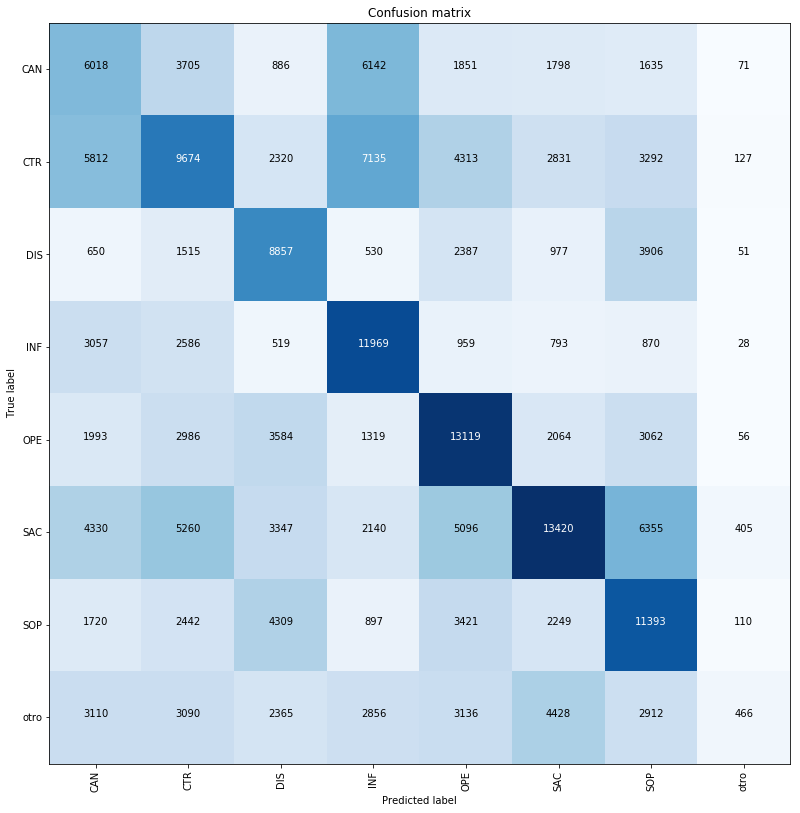


TESTING RESULTS


Accuracy:
0.34
              precision    recall  f1-score   support

         CAN       0.22      0.27      0.24      4674
         CTR       0.31      0.27      0.29      7594
         DIS       0.33      0.46      0.39      4022
         INF       0.35      0.56      0.43      4395
         OPE       0.37      0.47      0.42      5876
         SAC       0.47      0.33      0.39      8701
         SOP       0.34      0.43      0.38      5812
        otro       0.33      0.02      0.03      4935

   micro avg       0.34      0.34      0.34     46009
   macro avg       0.34      0.35      0.32     46009
weighted avg       0.35      0.34      0.33     46009



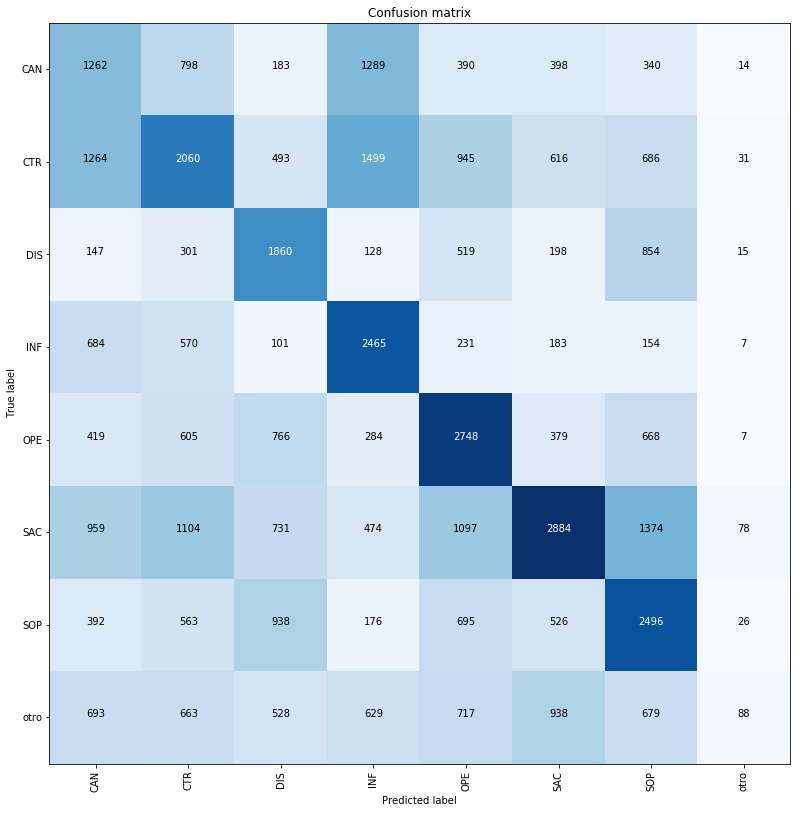

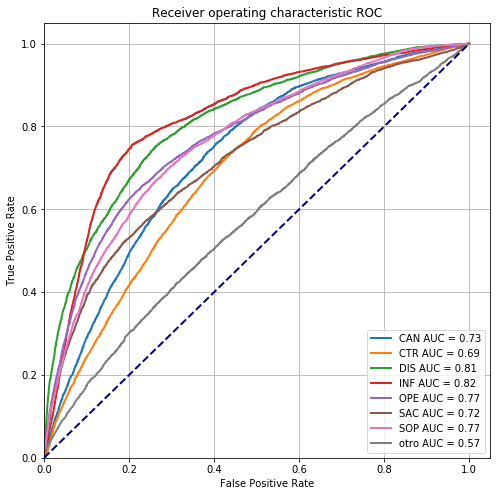

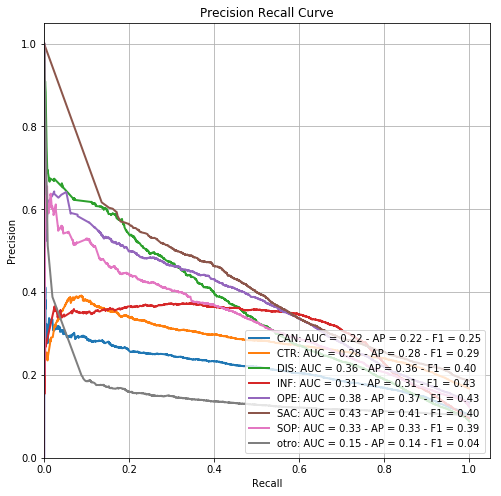


VALIDATION RESULTS

Threshold
[0.12, 0.12, 0.11, 0.14, 0.12, 0.14, 0.13, 0.13]

TESTING RESULTS



class  false positive rate  true positive rate
0  CAN   0.403910             0.758511          
1  CTR   0.425175             0.721659          
2  DIS   0.262723             0.752725          
3  INF   0.207129             0.756192          
4  OPE   0.229595             0.655821          
5  SAC   0.186843             0.519949          
6  SOP   0.263210             0.669965          
7  otro  0.312265             0.422232

class  false positive rate  true positive rate
0  CAN   0.000363             0.003209          
1  CTR   0.000208             0.000527          
2  DIS   0.016577             0.172054          
3  INF   0.000096             0.000000          
4  OPE   0.035158             0.225153          
5  SAC   0.000000             0.000000          
6  SOP   0.002264             0.015313          
7  otro  0.903491             0.922188

In [189]:
sequence_clf = ShallowModel('fasttext')
sequence_clf.fit(seq)

In [ ]:
sequence_clf = ShallowModel('tfidf')
sequence_clf.fit(seq)

### LSTM

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchcontrib.optim import SWA

#### Preparing Data - Call Tipification Sequence

In [45]:
vocab = {"<PAD>": 0, "DIS": 1, "SOP": 2, "SAC": 3, "CTR": 4, "INF": 5, "OPE": 6, "CAN": 7, "otro": 8}
tags = {"DIS": 0, "SOP": 1, "SAC": 2, "CTR": 3, "INF": 4, "OPE": 5, "CAN": 6, "otro": 7}

In [46]:
DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [47]:
def seq2Tensor(seq, vocab, tags):
    
    X = [[vocab[tag] for tag in sentence.split()] for sentence in seq.iteration.values]
    Y = torch.tensor([tags[tag] for tag in seq.label.values]).to(DEVICE)

    X_lengths = torch.tensor([len(sentence) for sentence in X], dtype=torch.int64).to(DEVICE)
    # create an empty matrix with padding tokens
    pad_token = vocab['<PAD>']
    longest_sent = max(X_lengths)
    batch_size = len(X)
    padded_X = np.ones((batch_size, longest_sent)) * pad_token
    # copy over the actual sequences
    for i, x_len in enumerate(X_lengths):
        sequence = X[i]
        padded_X[i, 0:x_len] = sequence[:x_len]
        
    return torch.tensor(padded_X, dtype = torch.long).to(DEVICE), X_lengths, Y, batch_size, longest_sent

In [48]:
X_train, X_lengths_train, Y_train, batch_size_train, longest_sent_train = seq2Tensor(seqTrain, vocab, tags, [])
X_train.shape, X_lengths_train.shape, Y_train.shape

(torch.Size([218261, 28]), torch.Size([218261]), torch.Size([218261]))

In [49]:
X_test, X_lengths_test, Y_test, batch_size_test, longest_sent_test = seq2Tensor(seqTest, vocab, tags)
X_test.shape, X_lengths_test.shape, Y_test.shape

(torch.Size([50574, 28]), torch.Size([50574]), torch.Size([50574]))

#### Preparing Data Notas

In [25]:
fasttext = FastTextVec()
fasttext.fit(claro_hist.lemma)

Number of features: 6400



In [26]:
X_text = [fasttext.transform(sequences) for sequences in seq.notas.tolist()]

In [ ]:
features = 300
padded_X_text = np.zeros((batch_size, longest_sent, features))
# copy over the actual sequences
for i, x_len in enumerate(X_lengths):
    padded_X_text[i, :x_len] = X_text[i]
padded_X_text = torch.tensor(padded_X_text, dtype = torch.float).to(DEVICE)

In [ ]:
padded_X_text.shape

#### Preparing Data Dates

In [50]:
def timeSeq2Tensor(seq, X_lengths, batch_size, longest_sent):
    
    month = seq.month.apply(lambda x: [int(num) for num in x.split()]).tolist()
    day = seq.day.apply(lambda x: [int(num) for num in x.split()]).tolist()
    features = 2
    padded_X_datetime = np.zeros((batch_size, longest_sent, features))
    # copy over the actual sequences
    for i, x_len in enumerate(X_lengths):
        padded_X_datetime[i, :x_len, 0] = month[i]
        padded_X_datetime[i, :x_len, 1] = day[i]

    return torch.tensor(padded_X_datetime, dtype = torch.long).to(DEVICE)

In [51]:
X_datetime_train = timeSeq2Tensor(seqTrain, X_lengths_train ,batch_size_train, longest_sent_train)
X_datetime_train.shape

torch.Size([218261, 28, 2])

In [52]:
X_datetime_test = timeSeq2Tensor(seqTest, X_lengths_test ,batch_size_test, longest_sent_test)
X_datetime_test.shape

torch.Size([50574, 28, 2])

#### Creating Model

In [53]:
class CallPredictor(nn.Module):
    def __init__(self, nb_layers, nb_lstm_units=100, embedding_dim=3, batch_size=3, bilstm = False, dropout = 0, hidden_size = 20):
        super(CallPredictor, self).__init__()

        self.vocab = {"<PAD>": 0, "DIS": 1, "SOP": 2, "SAC": 3, "CTR": 4, "INF": 5, "OPE": 6, "CAN": 7, "otro": 8}
        self.tags = {"<PAD>": 0, "DIS": 1, "SOP": 2, "SAC": 3, "CTR": 4, "INF": 5, "OPE": 6, "CAN": 7, "otro": 8}
        
        self.nb_lstm_layers = nb_layers
        self.nb_lstm_units = nb_lstm_units
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.bilstm = bilstm
        self.dropout = dropout
        self.hidden_size = hidden_size

        # don't count the padding tag for the classifier output
        self.nb_tags = len(self.tags) - 1

        # build actual NN
        self.__build_model()
        
    def __build_model(self):
        # build embedding layer first
        nb_vocab_words = len(self.vocab)

        # whenever the embedding sees the padding index it'll make the whole vector zeros
        padding_idx = self.vocab['<PAD>']
        self.word_embedding = nn.Embedding(
            num_embeddings=nb_vocab_words,
            embedding_dim=self.embedding_dim[0],
            padding_idx=padding_idx).to(DEVICE)
        
        self.month_embedding = nn.Embedding(
            num_embeddings=13,
            embedding_dim=self.embedding_dim[0],
            padding_idx=padding_idx).to(DEVICE)
        
        self.day_embedding = nn.Embedding(
            num_embeddings=32,
            embedding_dim=self.embedding_dim[0],
            padding_idx=padding_idx).to(DEVICE)

        # design LSTM
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim[1],
            hidden_size=self.nb_lstm_units,
            num_layers=self.nb_lstm_layers,
            batch_first=True,
            dropout = self.dropout if self.dropout and self.nb_lstm_layers > 1 else 0,
            bidirectional = self.bilstm).to(DEVICE)

        # output layer which projects back to tag space
        
        self.dense1 = nn.Linear(self.nb_lstm_units*2 if self.bilstm else self.nb_lstm_units, self.hidden_size).to(DEVICE)
        self.bn = nn.BatchNorm1d(num_features=self.hidden_size).to(DEVICE)
        self.dropout = nn.Dropout(self.dropout).to(DEVICE)
        self.dense2 = nn.Linear(self.hidden_size, self.nb_tags).to(DEVICE)
        
        self.init_weigths()
        
    def init_hidden(self):
        # the weights are of the form (nb_layers, batch_size, nb_lstm_units)
        hidden_a = torch.randn(self.nb_lstm_layers*2 if self.bilstm else self.nb_lstm_layers, self.batch_size, self.nb_lstm_units).to(DEVICE)
        hidden_b = torch.randn(self.nb_lstm_layers*2 if self.bilstm else self.nb_lstm_layers, self.batch_size, self.nb_lstm_units).to(DEVICE)

        return (hidden_a, hidden_b)
    
    def init_weigths(self):
        
        for param in self.lstm.named_parameters():
            if 'weight' in param[0]:
                nn.init.orthogonal_(param[1])
        nn.init.xavier_normal_(self.dense1.weight)
        nn.init.xavier_normal_(self.dense2.weight)
        print('weigths initializer: done!')

    def forward(self, X, X_lengths, X_datetime):
        # reset the LSTM hidden state. Must be done before you run a new batch. Otherwise the LSTM will treat
        # a new batch as a continuation of a sequence
        self.hidden = self.init_hidden()

        # ---------------------
        # 1. embed the input
        # Dim transformation: (batch_size, seq_len, 1) -> (batch_size, seq_len, embedding_dim)

        X = self.word_embedding(X)
        month = self.month_embedding(X_datetime[:,:,0])
        day = self.day_embedding(X_datetime[:,:,1])

        X = torch.cat((X, month, day), 2)

        # ---------------------
        # 2. Run through RNN
        # TRICK 2 ********************************
        # Dim transformation: (batch_size, seq_len, embedding_dim) -> (batch_size, seq_len, nb_lstm_units)
        
        # pack_padded_sequence so that padded items in the sequence won't be shown to the LSTM
        X = nn.utils.rnn.pack_padded_sequence(X, X_lengths, batch_first=True, enforce_sorted=False)

        # now run through LSTM
        X, self.hidden = self.lstm(X, self.hidden)
        
        # undo the packing operation
        X, _ = nn.utils.rnn.pad_packed_sequence(X, batch_first=True)
        
        # ---------------------
        # 3. Project to tag space
        # Dim transformation: (batch_size, seq_len, nb_lstm_units) -> (batch_size, nb_lstm_units)
        # Taking the last hidden state produced by the sequence.

        hidden = self.hidden[0].view(self.nb_lstm_layers,
                                     2, -1,
                                     self.nb_lstm_units)[-1] if self.bilstm else self.hidden[0][-1]
        hidden = hidden.contiguous()
        hidden = hidden.view(-1, self.nb_lstm_units*2 if self.bilstm else self.nb_lstm_units)

        # run through actual linear layer
        hidden = self.dropout(F.relu(self.bn(self.dense1(hidden))))
        hidden = F.log_softmax(self.dense2(hidden), dim=1)
        
        Y_hat = hidden
        return Y_hat

In [54]:
def train_model(model, X, X_lengths, X_date, Y):
    
    model.train()
    optimizer.zero_grad()
    prediction = model(X, X_lengths, X_date)
    loss = loss_fn(prediction, Y)
    
    num_corrects = (torch.max(prediction, 1)[1] == Y).sum()
    acc = 100.0 * num_corrects/Y.size(0)
    
    loss.backward()
    optimizer.step()
        
    return loss, acc

def test_model(model, X, X_lengths, X_date, Y):
    
    model.eval()
    with torch.no_grad():
        
        prediction = model(X, X_lengths, X_date)
        loss = loss_fn(prediction, Y)
        
        num_corrects = (torch.max(prediction, 1)[1] == Y).sum()
        acc = 100.0 * num_corrects/Y.size(0)

    return loss, acc

def plot_results(train, val, epochs, title, y_axis):
    plt.figure(figsize=(8,8))
    x = list(range(epochs))
    plt.plot(x, train, linewidth=2, label='Train')
    plt.plot(x, val, linewidth=2, label='Test')

    plt.xlabel('Epochs')
    plt.ylabel(y_axis)
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [117]:
def use_thread(function, function_input, model_):
    Q = queue.Queue()
    threads = {}
    output = []
    for idx, input_ in enumerate(function_input):
        threads[idx] = Thread(target = lambda q, arg: q.put(function(model_,arg[0],arg[1],arg[2],arg[3])), 
                              args=(Q, input_))
        threads[idx].start()
    for key in threads.keys():   
        threads[key].join()

    while not Q.empty():
        output.append(Q.get())

#         output = sorted(output, key = lambda x: x[1])

    return output

In [ ]:
counts = seq.label.value_counts()
maximum = counts.values.max()
rescale = torch.tensor([ maximum / counts[counts.index == label].values[0] for label in list(tags.keys())]).to(DEVICE)
rescale

In [60]:
model = CallPredictor(nb_layers = 2,
                      nb_lstm_units=100,
                      embedding_dim=(3,9),
                      batch_size=X_train.shape[0],
                      bilstm = False,
                      dropout = 0.2)

loss_fn = loss = nn.NLLLoss(reduction = 'mean')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4, amsgrad = True)
# optimizer = SWA(optimizer, swa_start=10, swa_freq=5, swa_lr=0.0)

weigths initializer: done!


In [61]:
train_samples = X_train.shape[0]
test_samples = X_test.shape[0]
batch_size = 512
train_div = int(train_samples / batch_size)
test_div = int(test_samples / batch_size)

train_loss_full = []
val_loss_full = []
train_acc_full = []
val_acc_full = []

epochs = 600

for epoch in range(epochs):
    for x_train, x_lengths_train, x_datetime_train, y_train in zip(torch.chunk(X_train, train_div, dim=0),
                                                                   torch.chunk(X_lengths_train, train_div, dim=0),
                                                                   torch.chunk(X_datetime_train, train_div, dim=0),
                                                                   torch.chunk(Y_train, train_div, dim=0)):
    
        tr_loss = []
        tr_acc = []
        
        random = torch.randperm(x_train.shape[0])

        loss, acc = train_model(model, 
                                x_train[random], 
                                x_lengths_train[random], 
#                                         X_text_train[random],
                                x_datetime_train[random],
                                y_train[random])
        tr_loss.append(loss)
        tr_acc.append(acc)
        
    train_loss = sum(tr_loss)/len(tr_loss)
    train_acc = sum(tr_acc)/len(tr_acc)
        
        
    for x_test, x_lengths_test, x_datetime_test, y_test in zip(torch.chunk(X_test, test_div, dim=0),
                                                               torch.chunk(X_lengths_test, test_div, dim=0),
                                                               torch.chunk(X_datetime_test, test_div, dim=0),
                                                               torch.chunk(Y_test, test_div, dim=0)):

        v_loss = []
        v_acc = []
        loss, acc = test_model(model, 
                               x_test, 
                               x_lengths_test, 
#                                    X_text_test,
                               x_datetime_test,
                               y_test)
        v_loss.append(loss)
        v_acc.append(acc)
        
    val_loss = sum(v_loss)/len(v_loss)
    val_acc = sum(v_acc)/len(v_acc)
        
        
    train_loss_full.append(train_loss)
    val_loss_full.append(val_loss)
    train_acc_full.append(train_acc)
    val_acc_full.append(val_acc)
    
    print(f'Epoch: {epoch+1:.2f}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:3f}, Val Acc: {val_acc:.2f}%')

Epoch: 1.00, Train Loss: 1.611, Train Acc: 53.00%, Val Loss: 1.807850, Val Acc: 43.00%
Epoch: 2.00, Train Loss: 1.649, Train Acc: 50.00%, Val Loss: 1.698081, Val Acc: 45.00%
Epoch: 3.00, Train Loss: 1.626, Train Acc: 52.00%, Val Loss: 1.682669, Val Acc: 47.00%
Epoch: 4.00, Train Loss: 1.675, Train Acc: 49.00%, Val Loss: 1.668758, Val Acc: 53.00%
Epoch: 5.00, Train Loss: 1.633, Train Acc: 51.00%, Val Loss: 1.654111, Val Acc: 53.00%
Epoch: 6.00, Train Loss: 1.597, Train Acc: 52.00%, Val Loss: 1.655105, Val Acc: 53.00%
Epoch: 7.00, Train Loss: 1.627, Train Acc: 53.00%, Val Loss: 1.665419, Val Acc: 53.00%
Epoch: 8.00, Train Loss: 1.634, Train Acc: 50.00%, Val Loss: 1.652590, Val Acc: 53.00%
Epoch: 9.00, Train Loss: 1.615, Train Acc: 50.00%, Val Loss: 1.651187, Val Acc: 53.00%
Epoch: 10.00, Train Loss: 1.608, Train Acc: 54.00%, Val Loss: 1.652688, Val Acc: 53.00%
Epoch: 11.00, Train Loss: 1.614, Train Acc: 55.00%, Val Loss: 1.643351, Val Acc: 53.00%
Epoch: 12.00, Train Loss: 1.592, Train Ac

Epoch: 95.00, Train Loss: 1.642, Train Acc: 52.00%, Val Loss: 1.695554, Val Acc: 52.00%
Epoch: 96.00, Train Loss: 1.647, Train Acc: 54.00%, Val Loss: 1.689495, Val Acc: 52.00%
Epoch: 97.00, Train Loss: 1.652, Train Acc: 54.00%, Val Loss: 1.692747, Val Acc: 52.00%
Epoch: 98.00, Train Loss: 1.662, Train Acc: 53.00%, Val Loss: 1.693176, Val Acc: 51.00%
Epoch: 99.00, Train Loss: 1.639, Train Acc: 50.00%, Val Loss: 1.698515, Val Acc: 52.00%
Epoch: 100.00, Train Loss: 1.636, Train Acc: 48.00%, Val Loss: 1.686588, Val Acc: 51.00%
Epoch: 101.00, Train Loss: 1.634, Train Acc: 48.00%, Val Loss: 1.692552, Val Acc: 51.00%
Epoch: 102.00, Train Loss: 1.644, Train Acc: 52.00%, Val Loss: 1.699789, Val Acc: 52.00%
Epoch: 103.00, Train Loss: 1.627, Train Acc: 56.00%, Val Loss: 1.689794, Val Acc: 51.00%
Epoch: 104.00, Train Loss: 1.647, Train Acc: 54.00%, Val Loss: 1.697777, Val Acc: 51.00%
Epoch: 105.00, Train Loss: 1.650, Train Acc: 51.00%, Val Loss: 1.695498, Val Acc: 52.00%
Epoch: 106.00, Train Loss:

Epoch: 188.00, Train Loss: 1.606, Train Acc: 52.00%, Val Loss: 1.709049, Val Acc: 51.00%
Epoch: 189.00, Train Loss: 1.620, Train Acc: 55.00%, Val Loss: 1.699694, Val Acc: 52.00%
Epoch: 190.00, Train Loss: 1.627, Train Acc: 47.00%, Val Loss: 1.707883, Val Acc: 51.00%
Epoch: 191.00, Train Loss: 1.645, Train Acc: 55.00%, Val Loss: 1.692534, Val Acc: 52.00%
Epoch: 192.00, Train Loss: 1.614, Train Acc: 45.00%, Val Loss: 1.708235, Val Acc: 52.00%
Epoch: 193.00, Train Loss: 1.663, Train Acc: 52.00%, Val Loss: 1.701139, Val Acc: 51.00%
Epoch: 194.00, Train Loss: 1.590, Train Acc: 51.00%, Val Loss: 1.706958, Val Acc: 51.00%
Epoch: 195.00, Train Loss: 1.621, Train Acc: 50.00%, Val Loss: 1.699175, Val Acc: 52.00%
Epoch: 196.00, Train Loss: 1.615, Train Acc: 52.00%, Val Loss: 1.714795, Val Acc: 51.00%
Epoch: 197.00, Train Loss: 1.608, Train Acc: 53.00%, Val Loss: 1.708818, Val Acc: 52.00%
Epoch: 198.00, Train Loss: 1.624, Train Acc: 50.00%, Val Loss: 1.702947, Val Acc: 52.00%
Epoch: 199.00, Train 

Epoch: 281.00, Train Loss: 1.625, Train Acc: 50.00%, Val Loss: 1.735619, Val Acc: 46.00%
Epoch: 282.00, Train Loss: 1.592, Train Acc: 50.00%, Val Loss: 1.723037, Val Acc: 51.00%
Epoch: 283.00, Train Loss: 1.605, Train Acc: 51.00%, Val Loss: 1.735020, Val Acc: 48.00%
Epoch: 284.00, Train Loss: 1.583, Train Acc: 52.00%, Val Loss: 1.715384, Val Acc: 52.00%
Epoch: 285.00, Train Loss: 1.628, Train Acc: 47.00%, Val Loss: 1.731495, Val Acc: 51.00%
Epoch: 286.00, Train Loss: 1.611, Train Acc: 50.00%, Val Loss: 1.731108, Val Acc: 51.00%
Epoch: 287.00, Train Loss: 1.562, Train Acc: 53.00%, Val Loss: 1.725695, Val Acc: 51.00%
Epoch: 288.00, Train Loss: 1.603, Train Acc: 53.00%, Val Loss: 1.728155, Val Acc: 51.00%
Epoch: 289.00, Train Loss: 1.577, Train Acc: 50.00%, Val Loss: 1.731987, Val Acc: 47.00%
Epoch: 290.00, Train Loss: 1.606, Train Acc: 50.00%, Val Loss: 1.718267, Val Acc: 51.00%
Epoch: 291.00, Train Loss: 1.559, Train Acc: 53.00%, Val Loss: 1.729502, Val Acc: 51.00%
Epoch: 292.00, Train 

Epoch: 374.00, Train Loss: 1.571, Train Acc: 54.00%, Val Loss: 1.728499, Val Acc: 49.00%
Epoch: 375.00, Train Loss: 1.567, Train Acc: 55.00%, Val Loss: 1.727261, Val Acc: 52.00%
Epoch: 376.00, Train Loss: 1.561, Train Acc: 48.00%, Val Loss: 1.729871, Val Acc: 51.00%
Epoch: 377.00, Train Loss: 1.545, Train Acc: 54.00%, Val Loss: 1.725421, Val Acc: 46.00%
Epoch: 378.00, Train Loss: 1.554, Train Acc: 51.00%, Val Loss: 1.729106, Val Acc: 51.00%
Epoch: 379.00, Train Loss: 1.554, Train Acc: 53.00%, Val Loss: 1.727771, Val Acc: 51.00%
Epoch: 380.00, Train Loss: 1.570, Train Acc: 50.00%, Val Loss: 1.726258, Val Acc: 51.00%
Epoch: 381.00, Train Loss: 1.565, Train Acc: 53.00%, Val Loss: 1.716610, Val Acc: 52.00%
Epoch: 382.00, Train Loss: 1.602, Train Acc: 50.00%, Val Loss: 1.736141, Val Acc: 47.00%
Epoch: 383.00, Train Loss: 1.581, Train Acc: 53.00%, Val Loss: 1.732958, Val Acc: 48.00%
Epoch: 384.00, Train Loss: 1.552, Train Acc: 50.00%, Val Loss: 1.727115, Val Acc: 51.00%
Epoch: 385.00, Train 

Epoch: 467.00, Train Loss: 1.556, Train Acc: 52.00%, Val Loss: 1.727915, Val Acc: 46.00%
Epoch: 468.00, Train Loss: 1.591, Train Acc: 52.00%, Val Loss: 1.732371, Val Acc: 46.00%
Epoch: 469.00, Train Loss: 1.608, Train Acc: 50.00%, Val Loss: 1.733770, Val Acc: 51.00%
Epoch: 470.00, Train Loss: 1.618, Train Acc: 54.00%, Val Loss: 1.725483, Val Acc: 50.00%
Epoch: 471.00, Train Loss: 1.564, Train Acc: 53.00%, Val Loss: 1.736677, Val Acc: 51.00%
Epoch: 472.00, Train Loss: 1.549, Train Acc: 53.00%, Val Loss: 1.736043, Val Acc: 47.00%
Epoch: 473.00, Train Loss: 1.592, Train Acc: 51.00%, Val Loss: 1.731183, Val Acc: 50.00%
Epoch: 474.00, Train Loss: 1.547, Train Acc: 54.00%, Val Loss: 1.726314, Val Acc: 51.00%
Epoch: 475.00, Train Loss: 1.561, Train Acc: 54.00%, Val Loss: 1.719856, Val Acc: 51.00%
Epoch: 476.00, Train Loss: 1.556, Train Acc: 52.00%, Val Loss: 1.728609, Val Acc: 46.00%
Epoch: 477.00, Train Loss: 1.617, Train Acc: 50.00%, Val Loss: 1.729388, Val Acc: 46.00%
Epoch: 478.00, Train 

Epoch: 560.00, Train Loss: 1.559, Train Acc: 52.00%, Val Loss: 1.725172, Val Acc: 51.00%
Epoch: 561.00, Train Loss: 1.576, Train Acc: 52.00%, Val Loss: 1.722019, Val Acc: 51.00%
Epoch: 562.00, Train Loss: 1.588, Train Acc: 52.00%, Val Loss: 1.723025, Val Acc: 51.00%
Epoch: 563.00, Train Loss: 1.592, Train Acc: 52.00%, Val Loss: 1.714872, Val Acc: 51.00%
Epoch: 564.00, Train Loss: 1.546, Train Acc: 52.00%, Val Loss: 1.719632, Val Acc: 50.00%
Epoch: 565.00, Train Loss: 1.568, Train Acc: 51.00%, Val Loss: 1.717092, Val Acc: 51.00%
Epoch: 566.00, Train Loss: 1.563, Train Acc: 59.00%, Val Loss: 1.723419, Val Acc: 46.00%
Epoch: 567.00, Train Loss: 1.566, Train Acc: 52.00%, Val Loss: 1.707728, Val Acc: 50.00%
Epoch: 568.00, Train Loss: 1.568, Train Acc: 52.00%, Val Loss: 1.708012, Val Acc: 51.00%
Epoch: 569.00, Train Loss: 1.543, Train Acc: 56.00%, Val Loss: 1.719854, Val Acc: 51.00%
Epoch: 570.00, Train Loss: 1.604, Train Acc: 53.00%, Val Loss: 1.716130, Val Acc: 51.00%
Epoch: 571.00, Train 

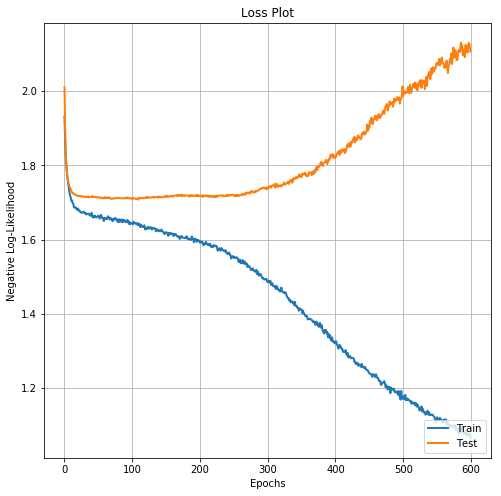

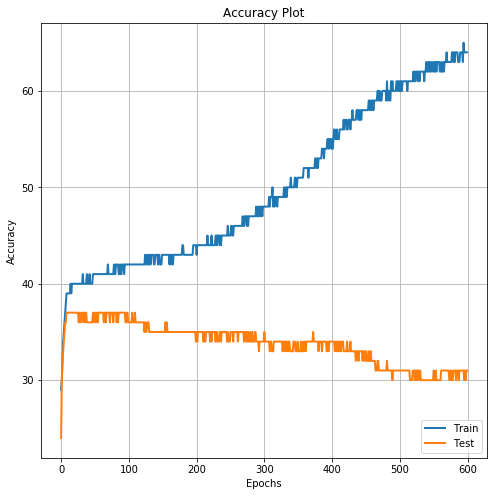

In [59]:
plot_results(train_loss_full, val_loss_full, epochs, 'Loss Plot', 'Negative Log-Likelihood')
plot_results(train_acc_full, val_acc_full, epochs, 'Accuracy Plot', 'Accuracy')

## LSTM with pytorch-lightning

In [1]:
import os
import ast
import pandas as pd
from sklearn.externals import joblib

import torch
import torchvision.transforms as transforms
import pytorch_lightning as ptl

from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from test_tube import Experiment

import matplotlib.pyplot as plt
from millenlp.embeddings import FastTextVec

In [2]:
vocab = {"<PAD>": 0, "DIS": 1, "SOP": 2, "SAC": 3, "CTR": 4, "INF": 5, "OPE": 6, "CAN": 7, "otro": 8}
tags = {"DIS": 0, "SOP": 1, "SAC": 2, "CTR": 3, "INF": 4, "OPE": 5, "CAN": 6, "otro": 7}

In [3]:
DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [4]:
fasttext = joblib.load('fasttext.pkl')

In [5]:
def seq2Tensor(seq, vocab, tags, embedding):
    
    X = [[vocab[tag] for tag in sentence.split()] for sentence in seq.iteration.values]
    X_lengths = torch.tensor([len(sentence) for sentence in X], dtype=torch.int64)
    month = seq.month.apply(lambda x: [int(num) for num in x.split()]).tolist()
    day = seq.day.apply(lambda x: [int(num) for num in x.split()]).tolist()
    text = [embedding.transform(ast.literal_eval(sequences)) for sequences in seq.notas.tolist()]
    
    Y = torch.tensor([tags[tag] for tag in seq.label.values])
    
    # create an empty matrix with padding tokens
    longest_sent = max(X_lengths)
    batch_size = len(X)
    
    padded_X = np.zeros((batch_size, longest_sent))
    padded_month = np.zeros((batch_size, longest_sent))
    padded_day = np.zeros((batch_size, longest_sent))
    padded_text = np.zeros((batch_size, longest_sent, embedding._num_features))
    
    # copy over the actual sequences
    for i, x_len in enumerate(X_lengths):
        sequence = X[i]
        padded_X[i, :x_len] = sequence[:x_len]
        padded_month[i, :x_len] = month[i]
        padded_day[i, :x_len] = day[i]
        padded_text[i, :x_len] = text[i]
    
    padded_X = torch.tensor(padded_X, dtype = torch.long)
    padded_month = torch.tensor(padded_month, dtype = torch.long)
    padded_day = torch.tensor(padded_day, dtype = torch.long)
    padded_text = torch.tensor(padded_text, dtype = torch.float)
    
    return TensorDataset(padded_X, X_lengths, padded_month, padded_day, padded_text, Y)
    #return TensorDataset(padded_X, X_lengths, padded_month, padded_day, Y)

In [6]:
seqTrain = pd.read_excel('seqTrain_Augmented.xlsx')
seqTest = pd.read_excel('seqTrain_Augmented.xlsx')

In [10]:
data_train = seq2Tensor(seqTrain, vocab, tags, fasttext)
data_val = seq2Tensor(seqTest[:int(seqTest.shape[0]/2)], vocab, tags, fasttext)
data_test = seq2Tensor(seqTest[int(seqTest.shape[0]/2):], vocab, tags, fasttext)

In [12]:
class CallPredictor(ptl.LightningModule):
    def __init__(self, nb_layers, nb_lstm_units=100, embedding_dim=3, batch_size=3, bilstm = False, dropout = 0, hidden_size = 20):
        super(CallPredictor, self).__init__()

        self.vocab = {"<PAD>": 0, "DIS": 1, "SOP": 2, "SAC": 3, "CTR": 4, "INF": 5, "OPE": 6, "CAN": 7, "otro": 8}
        self.tags = {"<PAD>": 0, "DIS": 1, "SOP": 2, "SAC": 3, "CTR": 4, "INF": 5, "OPE": 6, "CAN": 7, "otro": 8}
        
        self.nb_lstm_layers = nb_layers
        self.nb_lstm_units = nb_lstm_units
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.bilstm = bilstm
        self.dropout = dropout
        self.hidden_size = hidden_size
        self.loss = torch.nn.NLLLoss(reduction = 'mean')

        # don't count the padding tag for the classifier output
        self.nb_tags = len(self.tags) - 1

        # build actual NN
        self.__build_model()
        
    def __build_model(self):
        # build embedding layer first
        nb_vocab_words = len(self.vocab)

        # whenever the embedding sees the padding index it'll make the whole vector zeros
        padding_idx = self.vocab['<PAD>']
        self.word_embedding = torch.nn.Embedding(
            num_embeddings=nb_vocab_words,
            embedding_dim=self.embedding_dim[0],
            padding_idx=padding_idx).to(DEVICE)
        
        self.month_embedding = torch.nn.Embedding(
            num_embeddings=13,
            embedding_dim=self.embedding_dim[0],
            padding_idx=padding_idx).to(DEVICE)
        
        self.day_embedding = torch.nn.Embedding(
            num_embeddings=32,
            embedding_dim=self.embedding_dim[0],
            padding_idx=padding_idx).to(DEVICE)

        # design LSTM
        self.lstm = torch.nn.LSTM(
            input_size=self.embedding_dim[1],
            hidden_size=self.nb_lstm_units,
            num_layers=self.nb_lstm_layers,
            batch_first=True,
            dropout = self.dropout if self.dropout and self.nb_lstm_layers > 1 else 0,
            bidirectional = self.bilstm).to(DEVICE)

        # output layer which projects back to tag space
        
        self.dense1 = torch.nn.Linear(self.nb_lstm_units*2 if self.bilstm else self.nb_lstm_units, self.hidden_size).to(DEVICE)
        self.bn = torch.nn.BatchNorm1d(num_features=self.hidden_size).to(DEVICE)
        self.dropout = torch.nn.Dropout(self.dropout).to(DEVICE)
        self.dense2 = torch.nn.Linear(self.hidden_size, self.nb_tags).to(DEVICE)
        
        self.init_weigths()
        
    def init_hidden(self):
        # the weights are of the form (nb_layers, batch_size, nb_lstm_units)
        hidden_a = torch.randn(self.nb_lstm_layers*2 if self.bilstm else self.nb_lstm_layers, self.batch_size, self.nb_lstm_units).to(DEVICE)
        hidden_b = torch.randn(self.nb_lstm_layers*2 if self.bilstm else self.nb_lstm_layers, self.batch_size, self.nb_lstm_units).to(DEVICE)

        return (hidden_a, hidden_b)
    
    def init_weigths(self):
        
        for param in self.lstm.named_parameters():
            if 'weight' in param[0]:
                torch.nn.init.orthogonal_(param[1])
        torch.nn.init.xavier_normal_(self.dense1.weight)
        torch.nn.init.xavier_normal_(self.dense2.weight)
        print('weigths initializer: done!')

    def forward(self, X, X_lengths, month, day, text):
        # reset the LSTM hidden state. Must be done before you run a new batch. Otherwise the LSTM will treat
        # a new batch as a continuation of a sequence
        self.hidden = self.init_hidden()

        # ---------------------
        # 1. embed the input
        # Dim transformation: (batch_size, seq_len, 1) -> (batch_size, seq_len, embedding_dim)

        X = self.word_embedding(X)
        month = self.month_embedding(month)
        day = self.day_embedding(day)

        X = torch.cat((X, month, day, text), 2)

        # ---------------------
        # 2. Run through RNN
        # TRICK 2 ********************************
        # Dim transformation: (batch_size, seq_len, embedding_dim) -> (batch_size, seq_len, nb_lstm_units)
        
        # pack_padded_sequence so that padded items in the sequence won't be shown to the LSTM
        X = torch.nn.utils.rnn.pack_padded_sequence(X, X_lengths, batch_first=True, enforce_sorted=False)

        # now run through LSTM
        X, self.hidden = self.lstm(X, self.hidden)
        
        # undo the packing operation
        X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)
        
        # ---------------------
        # 3. Project to tag space
        # Dim transformation: (batch_size, seq_len, nb_lstm_units) -> (batch_size, nb_lstm_units)
        # Taking the last hidden state produced by the sequence.

        hidden = self.hidden[0].view(self.nb_lstm_layers,
                                     2, -1,
                                     self.nb_lstm_units)[-1] if self.bilstm else self.hidden[0][-1]
        hidden = hidden.contiguous()
        hidden = hidden.view(-1, self.nb_lstm_units*2 if self.bilstm else self.nb_lstm_units)

        # run through actual linear layer
        hidden = self.dropout(F.relu(self.bn(self.dense1(hidden))))
        hidden = F.log_softmax(self.dense2(hidden), dim=1)
        
        Y_hat = hidden
        return Y_hat

    def my_loss(self, y_hat, y):
        return self.loss(y_hat, y)
    
    def my_acc(self, y_hat, y):
        num_corrects = (torch.max(y_hat, 1)[1] == y).sum()
        return 100.0 * num_corrects/y.size(0)

    def training_step(self, batch, batch_nb):
        x, lengths, month, day, text, y = batch
        y_hat = self.forward(x,lengths,month,day,text)
        return {'loss': self.my_loss(y_hat, y), 'acc': self.my_acc(y_hat, y)}

    def validation_step(self, batch, batch_nb):
        x, lengths, month, day, text, y = batch
        y_hat = self.forward(x,lengths,month,day,text)
        return {'val_loss': self.my_loss(y_hat, y), 'val_acc':self.my_acc(y_hat, y)}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_val = torch.stack([x['val_acc'] for x in outputs]).double().mean()
        return {'avg_val_loss': avg_loss, 'avg_val_acc':avg_val}

    def configure_optimizers(self):
        return [torch.optim.Adam(self.parameters(), lr=0.0005, weight_decay=5e-4, amsgrad = True)]

    @ptl.data_loader
    def tng_dataloader(self):
        return DataLoader(data_train, batch_size=self.batch_size)

    @ptl.data_loader
    def val_dataloader(self):
        return DataLoader(data_val, batch_size=self.batch_size)
    
    @ptl.data_loader
    def test_dataloader(self):
        return DataLoader(data_test, batch_size=self.batch_size)

In [13]:
model = CallPredictor(nb_layers = 2,
                      nb_lstm_units=100,
                      embedding_dim=(3,14),
                      batch_size=256,
                      bilstm = False,
                      dropout = 0.2)

exp = Experiment(save_dir=os.getcwd())
trainer = ptl.Trainer(experiment=exp, max_nb_epochs=200, train_percent_check=1, gpus=[0],track_grad_norm=2)

weigths initializer: done!
VISIBLE GPUS: 0
gpu available: True, used: True


In [14]:
trainer.fit(model)

# view tensorflow logs 
print(f'View tensorboard logs by running\ntensorboard --logdir {os.getcwd()}')
print('and going to http://localhost:6006 on your browser')

  0%|          | 2/1241 [00:00<01:26, 14.29it/s, batch_nb=0, epoch=0, gpu=0, tng_loss=2.334, v_nb=3]

              Name         Type  Params
0             loss      NLLLoss       0
1   word_embedding    Embedding      27
2  month_embedding    Embedding      39
3    day_embedding    Embedding      96
4             lstm         LSTM  127200
5           dense1       Linear    2020
6               bn  BatchNorm1d      40
7          dropout      Dropout       0
8           dense2       Linear     168


100%|██████████| 1241/1241 [00:50<00:00, 22.85it/s, avg_val_acc=36.3, avg_val_loss=1.73, batch_nb=826, epoch=199, gpu=0, tng_loss=1.776, v_nb=3] 

View tensorboard logs by running
tensorboard --logdir /home/daniel/Claro
and going to http://localhost:6006 on your browser
